In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
from itertools import permutations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

In [3]:
data_path = '../data/corn_not_corn%2.csv'
data = pd.read_csv(data_path, index_col=0)
data['year'] = data['year'].apply(int)
data = data.sort_values(['year', 'county_name', 'commodity_desc'])
data = data.set_index('year')
data = data.drop(columns=['percent'])

# Just get the corn
data = data[data['commodity_desc'] == 'CORN']
data = data.drop(columns=['commodity_desc'])
county_names = data['county_name'].unique()

corn = pd.DataFrame(index=np.arange(1919, 2021))
for county in county_names:
    df = data[data['county_name'] == county]
    corn[county] = df['value']

corn = corn.interpolate()


In [32]:
perms = np.array([np.array(p) for p in permutations(np.arange(4))])[:6] # Use for data augmentation

X = corn.to_numpy()
X_max = np.max(X)
X = X/X_max
year = 1919
test_size = 5
window = 10

train_data = [] # Train data starts 1919-1979 and 1994-2005, predict 1929-1989 and 2004-2015
val_data = []   # Val data starts 1980-1984, predict 1990-1994
test_data = []  # Test data starts 2006-2010, predict 2016-2020
# We toss out 1985-1993 and predicting on 1995-2003
for i in range(len(X) - window):
    X_temp = X.copy()
    for j in range(len(X[0])): # Make a data point for each county that year
        for perm in perms:
            sample = X_temp[i:i+window]
            sample = sample[:, perm]
            label = X_temp[i+window][0]
            if year+i in np.arange(1980, 1985): # val
                val_data.append([sample, label])
            elif year+i in np.arange(2006, 2011): # test
                test_data.append([sample, label])
            elif year+i not in np.arange(1985, 1995): # train
                train_data.append([sample, label])
        X_temp = np.roll(X_temp, 1, axis=1)
        
print(len(train_data), len(val_data), len(test_data))
        

batch_size = 24
train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=False) # TODO: Actually shuffle
val_loader = DataLoader(val_data,
                       batch_size=batch_size,
                       shuffle=False)
test_loader =  DataLoader(test_data,
                         batch_size=1,
                         shuffle=False)

# plt.plot(np.arange(1919, 2021)[60:], X.T[0][60:]*X_max)
# plt.plot(np.arange(1919, 2021)[60:], X.T[1][60:]*X_max)
# plt.plot(np.arange(1919, 2021)[60:], X.T[2][60:]*X_max)
# plt.plot(np.arange(1919, 2021)[60:], X.T[3][60:]*X_max)
# plt.grid()
# plt.show()

1728 120 120


In [33]:
class CNN(nn.Module):
    def __init__(self, kernel_len=3):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(kernel_len, 4), padding=(1,0), padding_mode='reflect')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(kernel_len, 1), padding=(1,0), padding_mode='reflect')
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.5)
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1))
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(in_features=64*5, out_features=100)
        self.linear2 = nn.Linear(in_features=100, out_features=1)

    def forward(self, x):
        output = self.relu(self.conv1(x))
        output = self.relu(self.conv2(output))
        output = self.dropout(output)
        output = self.maxpool(output)
        output = self.flatten(output)
        output = self.relu(self.linear1(output))
        return self.linear2(output)

In [35]:
torch.manual_seed(1)

def val_error(model):
    model.eval()
    all_losses = []
    for (x, y_truth) in val_loader:
        x = x.unsqueeze(1).float()
        y_truth = y_truth.float()
        outputs = model(x)
        outputs = outputs.flatten()
        loss = RMSE(outputs, y_truth)
        all_losses.append(loss.item())
    return np.mean(all_losses)

model = CNN()
MSE = nn.MSELoss()
def RMSE(pred, y_truth):
    return torch.sqrt(MSE(pred, y_truth))

optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 500
loop = tqdm(total=len(train_loader)*num_epochs, position=0)
print_every = 5

train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    for (x, y_truth) in train_loader:
        optimizer.zero_grad()

        x = x.unsqueeze(1).float()
        y_truth = y_truth.float()
        
        outputs = model(x)
        outputs = outputs.flatten()
        loss = RMSE(outputs, y_truth)
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        loop.update()

    if epoch % print_every == 0:
        loop.set_description('epoch:{} loss:{:.5f}'.format(epoch, loss.item()))
    train_losses.append(np.mean(epoch_loss))
    val_loss = val_error(model)
    val_losses.append(val_loss)

epoch:495 loss:0.04279: 100%|██████████| 36000/36000 [02:19<00:00, 275.43it/s]

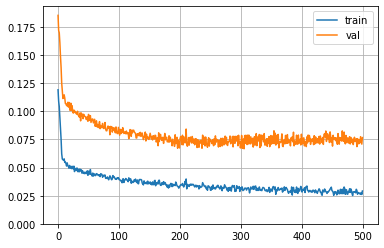

epoch:490 loss:0.05004: 100%|██████████| 7500/7500 [00:39<00:00, 348.61it/s]

In [12]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.ylim(bottom=0)
plt.grid()
plt.show()

In [28]:
def test_error(model):
    model.eval()
    all_losses = []
    for (x, y_truth) in test_loader:
        x = x.unsqueeze(1).float()
        y_truth = y_truth.float()
        outputs = model(x)
        outputs = outputs.flatten()
        outputs *= X_max   # Reverse normalization
        y_truth *= X_max
        test_mse = MSE(outputs, y_truth).item()
        test_mae = MAE(outputs, y_truth).item()
        print(test_mae)
        all_losses.append(loss.item())
    return np.mean(all_losses)

test_mse = test_error(model)

63145.7890625
33620.0234375
16779.935546875
54175.828125
42506.984375
18646.794921875
19840.28515625
38833.59375
17573.3046875
7217.001953125
15315.244140625
21466.921875
2948.453125
9601.734375
1034.62109375
8106.828125
22673.3125
26145.12890625
11606.33203125
45196.6171875


In [24]:
arr = np.array([[0, 1, 2, 3],
          [0, 1, 2, 3],
          [0, 1, 2, 3],
          [0, 1, 2, 3],
          [0, 1, 2, 3],
          [0, 1, 2, 3],
          [0, 1, 2, 3],
          [0, 1, 2, 3]])

print(perms[:6])

[[0 1 2 3]
 [0 1 3 2]
 [0 2 1 3]
 [0 2 3 1]
 [0 3 1 2]
 [0 3 2 1]
 [1 0 2 3]]
